<a href="https://colab.research.google.com/github/AbdElRahmanFarhan/box_semantic_segmentation/blob/main/mask_rcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pycocotools
!pip install coco-eval

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.1 MB/s eta 0:00:00
  Created wheel for coco-eval: filename=coco_eval-0.0.4-py3-none-any.whl size=5016 sha256=03e01efa405ab0b063be128c2df83a6b669c90cdd41b6fc8600b2e065d39bfea
  Store

In [3]:
import zipfile

zip_file_path = '/content/drive/MyDrive/OSCD.zip'
dataset_folder = '/content/drive/MyDrive/OSCD/'

if len(os.listdir(dataset_folder)) == 0:
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      zip_ref.extractall(dataset_folder)

  print(f"Unzipped to: {dataset_folder}")

In [4]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

train_folder = os.path.join(dataset_folder, 'coco_carton/oneclass_carton/images/train2017')
val_folder = os.path.join(dataset_folder, 'coco_carton/oneclass_carton/images/val2017')
train_annotation = os.path.join(dataset_folder, 'coco_carton/oneclass_carton/annotations/instances_train2017.json')
val_annotation = os.path.join(dataset_folder, 'coco_carton/oneclass_carton/annotations/instances_val2017.json')

In [5]:
import torch
from torchvision.datasets import CocoDetection
import torchvision.transforms as T
from PIL import Image
from torchvision.tv_tensors import Mask
from torchvision.transforms.functional import to_tensor
from skimage.draw import polygon as sk_polygon

class OSCDDataset(CocoDetection):
    def __init__(self, img_folder, ann_file):
        super().__init__(img_folder, ann_file, transforms=None)

    def __getitem__(self, idx):
        img, anns = super().__getitem__(idx)

        if anns:
          labels = []
          areas = []
          iscrowd = []
          masks = []
          boxes = []
          ids = []
          for ann in anns:
              x, y, w, h = list(map(int, ann['bbox']))
              boxes.append([x, y, x + w, y + h])
              labels.append(ann['category_id'])
              areas.append(ann['area'])
              iscrowd.append(ann['iscrowd'])
              mask = self.get_mask(ann['segmentation'], img.size[1], img.size[0])
              masks.append(mask)
              ids.append(ann['id'])

          labels = torch.tensor(labels, dtype=torch.int64)
          areas = torch.tensor(areas, dtype=torch.float32)
          iscrowd = torch.tensor(iscrowd, dtype=torch.uint8)
          boxes = torch.tensor(boxes, dtype=torch.int64)
          masks = torch.stack(masks, dim=0)
          ids = torch.tensor(ids, dtype=torch.int64)
          img_id = torch.tensor(ann['image_id'], dtype=torch.int64)

          target = {
              "boxes": boxes,
              "labels": labels,
              "image_id": img_id,
              "ids": ids,
              "area": areas,
              "iscrowd": iscrowd,
              "masks": Mask(masks),
          }
        else:
          target = {}
        img = to_tensor(img)
        return img, target

    def get_mask(self, segmentation, height, width):
        mask = torch.zeros((height, width), dtype=torch.bool)
        poly_x = segmentation[0][::2]
        poly_y = segmentation[0][1::2]
        rr, cc = sk_polygon(poly_y, poly_x, shape=(height, width))
        mask[rr, cc] = 1
        return mask


In [6]:
train_dataset = OSCDDataset(train_folder, train_annotation)
val_dataset = OSCDDataset(val_folder, val_annotation)

loading annotations into memory...
Done (t=3.13s)
creating index...
index created!
loading annotations into memory...
Done (t=0.61s)
creating index...
index created!


In [7]:
def collate_fn(batch):
    images, targets = [], []
    for (image, target) in batch:
      if not target:
        continue
      else:
        images.append(image)
        targets.append(target)
    return images, targets

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

In [8]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
# print(model)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 161MB/s]


In [9]:
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, 256, 2)

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [11]:
train_dataset = next(iter(train_loader))
images_list = train_dataset[0]
targets_list = train_dataset[1]
print(type(images_list[0]))
print(type(targets_list[0]))

<class 'torch.Tensor'>
<class 'dict'>


In [12]:
images = [image.to(device) for image in images_list]
targets = [{k: v.to(device) for k, v in t.items()} for t in targets_list]

In [13]:
model.to(device)
print("model")

model


In [14]:
output = model(images, targets)

In [15]:
print(output)

{'loss_classifier': tensor(1.1699, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(1.0249, device='cuda:0', grad_fn=<DivBackward0>), 'loss_mask': tensor(3.9887, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_objectness': tensor(0.9361, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.1302, device='cuda:0', grad_fn=<DivBackward0>)}


In [16]:
model.eval()
print("start eval")

start eval


In [17]:
preds = model(images)

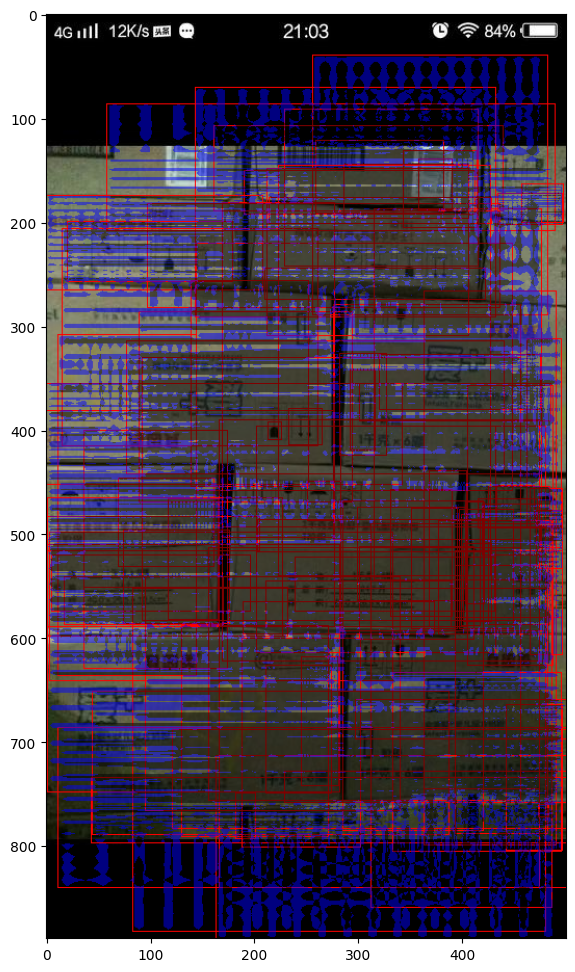

In [18]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

img = images[0]
pred = preds[0]
pred_boxes = pred["boxes"]
pred_labels = pred["labels"]

plt_img = draw_bounding_boxes(img, pred_boxes, colors="red")
masks = (pred["masks"] > 0.7).squeeze(1)
plt_img = draw_segmentation_masks(plt_img, masks, alpha=0.5, colors="blue")
plt.figure(figsize=(12, 12))
plt.imshow(plt_img.permute(1, 2, 0))

In [19]:
epochs = 1
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

In [24]:
def train_one_epoch(model, optimizer, train_loader, device):
    model.train()
    train_loss = torch.zeros(1).to(device)
    val_loss = torch.zeros(1).to(device)
    counter = 0
    for  i, (images, targets) in enumerate(train_loader):
      if len(targets) != 0:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        losses = model(images, targets)
        loss = sum(loss for loss in losses.values())
        optimizer.zero_grad()
        loss.backward()
        train_loss += loss
        optimizer.step()
        lr_scheduler.step()
        counter += 1
        break

    train_loss /= counter if counter != 0 else 1
    return train_loss


In [25]:
train_loss = train_one_epoch(model, optimizer, train_loader, device)
print(train_loss)

tensor([2.3538], device='cuda:0', grad_fn=<DivBackward0>)


In [26]:
def prepare_for_coco_segmentation(predictions, targets):
    coco_results = []
    for prediction, target in zip(predictions, targets):
        masks = prediction["masks"]
        masks = masks > 0.5
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()
        rles = [
            mask_util.encode(np.array(mask[0, :, :, np.newaxis], dtype=np.uint8, order="F"))[0] for mask in masks
        ]
        for rle in rles:
            rle["counts"] = rle["counts"].decode("utf-8")
        coco_results.extend(
            [
                {
                    "image_id": target["image_id"].item(),
                    "category_id": labels[k],
                    "segmentation": rle,
                    "score": scores[k],
                }
                for k, rle in enumerate(rles)
            ]
        )
    return coco_results

In [42]:
from coco_eval import CocoEvaluator
import numpy as np
import pycocotools.mask as mask_util

def evaluate(model, data_loader, device):
    model.eval()
    epoch_loss = torch.zeros(1).to(device)
    coco_eval = CocoEvaluator(data_loader.dataset.coco, ['segm'])
    for i, (images, targets) in enumerate(data_loader):
      images = [image.to(device) for image in images]
      with torch.no_grad():
        predictions = model(images)
        predictions = [{k: v.to('cpu') for k, v in o.items()} for o in predictions]
        coco_results = prepare_for_coco_segmentation(predictions, targets)
        coco_eval.update(coco_results)
        break
    coco_eval.synchronize_between_processes()
    coco_eval.accumulate()
    return coco_eval

In [43]:
coco_eval = evaluate(model, val_loader, device)
print(coco_eval.summarize())

Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: segm
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.182
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.430
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.072
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.200
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.200
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.450
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area